# PCA - 150m

In [73]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.wkt import loads
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
from sklearn.linear_model import LinearRegression

### Choose night time temperatures in July

In [6]:
temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']

In [7]:
# choose all times between 11pm and 6am in July
temp = temp[(temp['datetime_UTC'].dt.hour>=23) | (temp['datetime_UTC'].dt.hour<6)]
temp = temp[(temp['datetime_UTC'].dt.month==7)]
temp_result = temp.groupby('station_id').mean(numeric_only=True)

In [8]:
print(temp_result)

                value
station_id           
FRASHA      17.384516
FRBETZ      18.499631
FRBRUH      18.681705
FRDIET      16.922488
FRDREI      18.395069
FREBNE      15.556083
FREICH      16.675346
FRFRIE      18.341014
FRGART      18.357788
FRGLBA      16.420968
FRGUNT      16.746728
FRHAID      18.344839
FRHBHF      19.055853
FRHERD      19.007650
FRHOCH      16.778479
FRHOLZ      17.871567
FRIHOC      17.191336
FRINST      19.600138
FRKART      19.692673
FRLAND      17.699447
FRLORE      17.066313
FRMERZ      16.635161
FRMESS      18.795806
FROPFS      16.558940
FROWIE      18.364977
FRPDAS      18.493917
FRRIES      18.808387
FRSEEP      18.413134
FRSTGA      18.632488
FRSTGE      18.516221
FRSTUH      18.801060
FRTIEN      16.376590
FRUNIK      19.291567
FRUWIE      18.135991
FRVAUB      17.823272
FRWAHS      15.966452
FRWEIN      18.648525
FRWILD      17.125023
FRWITT      18.801705
FRWSEE      17.621198
FRZAHR      18.148940


### Import Urban Form Parameters

In [18]:
# import and drop index
params = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_150.parquet')

In [19]:
params = params[params['station_id']!='FRTECH']
params = params.merge(temp_result, left_on='station_id', right_on='station_id',how='inner')

In [20]:
params.index = params['station_id']

In [21]:
items = [
    'BuAre_count', 'BuAre_sum', 'BuAre_mean', 'BuAre_std', 
    'BuHt_mean', 'BuHt_std', 
    'BuPer_mean', 'BuPer_std', 
    'BuLAL_mean', 'BuLAL_std', 
    'BuCCD_mean_mean', 'BuCCD_mean_std', 
    'BuCor_mean', 'BuCor_std', 
    'CyAre_sum', 'CyAre_mean', 'CyAre_std', 
    'CyInd_mean', 'CyInd_std', 
    'BuCWA_mean', 'BuCWA_std', 
    'BuCon_mean', 'BuCon_std', 
    'BuElo_mean', 'BuElo_std', 
    'BuERI_mean', 'BuERI_std', 
    'BuFR_mean', 'BuFR_std', 
    'BuFF_mean', 'BuFF_std', 
    'BuFD_mean', 'BuFD_std', 
    'BuRec_mean', 'BuRec_std', 
    'BuShI_mean', 'BuShI_std', 
    'BuSqC_mean', 'BuSqC_std', 
    'BuSqu_mean', 'BuSqu_std', 
    'BuAdj', 
    'BuIBD', 
    'BuSWR_mean', 'BuSWR_std', 
    'BuOri_mean', 'BuOri_std', 
    'BuAli_mean', 'BuAli_std', 
    'StrAli_mean', 'StrAli_std', 
    'StrW_mean', 'StrW_std', 
    'StrWD_mean', 'StrWD_std', 
    'StrOpe_mean', 'StrOpe_std', 
    'StrHW_mean', 'StrHW_std', 
    'StrLen_mean', 'StrLen_std', 
    'StrCNS_mean', 'StrCNS_std', 
    'BpM_mean', 'BpM_std', 
    'StrLin_mean', 'StrLin_std', 
    'StrClo400_mean', 'StrClo400_std', 
    'StrBet400_mean', 'StrBet400_std', 
    'StrSCl_mean', 'StrSCl_std', 
    'StrCyc400_mean', 'StrCyc400_std', 
    'StrENR400_mean', 'StrENR400_std', 
    'StrGam400_mean', 'StrGam400_std', 
    'StrDeg_mean', 'StrDeg_std', 
    'StrMes400_mean', 'StrMes400_std',
    'StrClo1200_mean', 'StrClo1200_std', 
    'StrBet1200_mean', 'StrBet1200_std',  
    'StrCyc1200_mean', 'StrCyc1200_std', 
    'StrENR1200_mean', 'StrENR1200_std', 
    'StrGam1200_mean', 'StrGam1200_std', 
    'StrMes1200_mean', 'StrMes1200_std'
]


In [22]:
params = params[items]
params = params.merge(temp_result, left_on='station_id', right_on='station_id',how='inner')

In [23]:
# standardize data
scaler = StandardScaler()
params_scaled = scaler.fit_transform(params)
params_scaled = pd.DataFrame(params_scaled, columns=params.columns, index=params.index)
params_scaled = params_scaled.dropna(thresh=params_scaled.shape[0] - 7, axis=1)

# Correlate Parameters

In [26]:
corr = params_scaled.corr()

In [27]:
long_df = corr.reset_index().melt(id_vars='index', var_name='Variable', value_name='Correlation')

# Create the heatmap using Altair
heatmap = alt.Chart(long_df).mark_rect().encode(
    x=alt.X('index:N', title='Variables', sort=None),  # Column names
    y=alt.Y('Variable:N', title='Variables', sort=None),  # Row names
    color=alt.Color('Correlation:Q', scale=alt.Scale(scheme='viridis'), title='Correlation'),
    tooltip=['index', 'Variable', 'Correlation']  # Tooltips for interactivity
).properties(
    width=1000,
    height=1000,
    title='Correlation Heatmap'
).interactive()

# Display the heatmap
heatmap.show()

alt.Chart(...)

# PCA

In [36]:
# select all but values column
X_scaled = params_scaled.drop('value', axis=1)

In [37]:
# Select the relevant variables and standardize them
X_scaled = params_scaled.dropna()

In [42]:
# Perform PCA
pca = PCA()
pca.fit(X_scaled)

PCA()

In [43]:
# Get the loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))], index=params_scaled.columns)
print(loadings)

                      PC1       PC2       PC3       PC4       PC5       PC6  \
BuAre_count     -0.052569  0.024034 -0.235993 -0.111964  0.027021  0.053186   
BuAre_sum        0.124129  0.043817 -0.037179 -0.036619 -0.082252 -0.099877   
BuAre_mean       0.078373 -0.012530  0.143106 -0.000165 -0.028087 -0.067792   
BuAre_std        0.106019  0.022713  0.161613 -0.015155 -0.032076 -0.074454   
BuHt_mean        0.152732 -0.042970  0.021094  0.038921 -0.018787 -0.106752   
...                   ...       ...       ...       ...       ...       ...   
StrGam1200_mean  0.107797 -0.056730 -0.132051  0.177910 -0.065266 -0.167284   
StrGam1200_std  -0.106045  0.139796  0.094797  0.022466  0.109712 -0.053465   
StrMes1200_mean  0.135510 -0.104758 -0.143038  0.113455 -0.108376 -0.083724   
StrMes1200_std  -0.048880  0.207005  0.024114  0.129348  0.121702 -0.168719   
value            0.131420  0.021108  0.003521 -0.032607  0.003152 -0.012891   

                      PC7       PC8       PC9      

In [44]:
# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

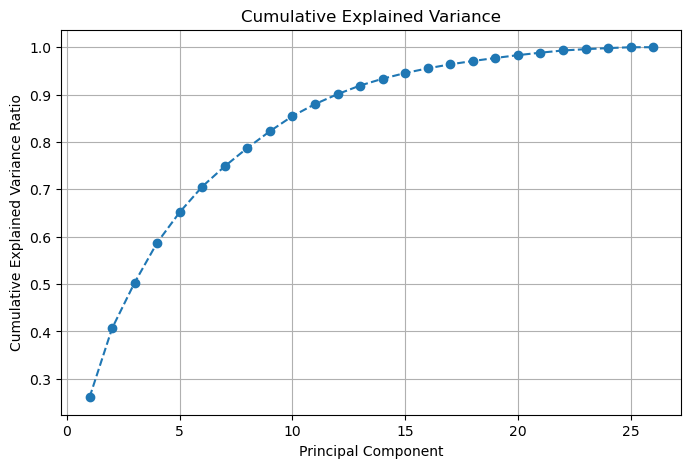

In [45]:
# Create a cumulative variance plot
cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

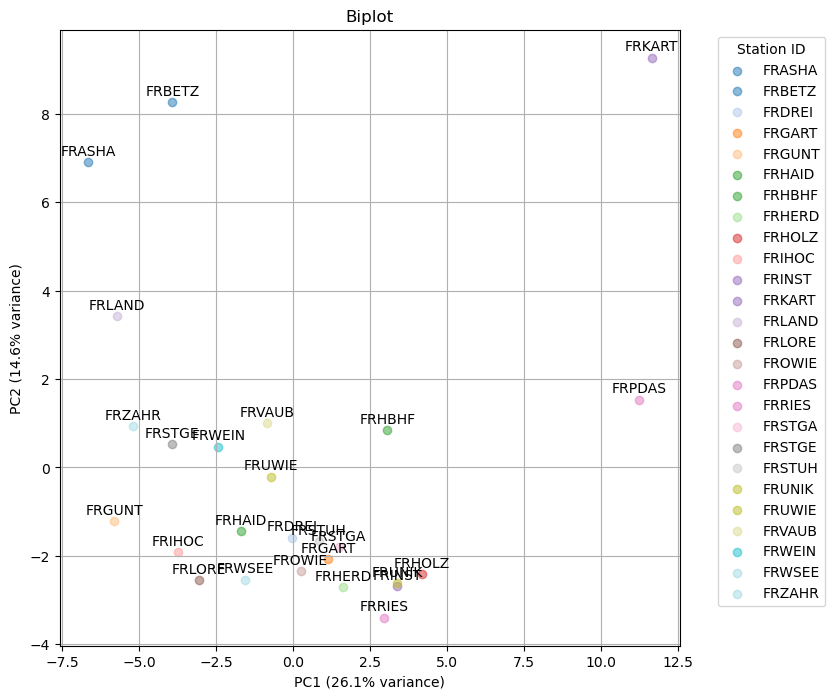

In [46]:
# Assuming params_mean has a 'station_id' column
station_ids = params_scaled.dropna().index
unique_station_ids = station_ids.unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_station_ids)))
color_map = dict(zip(unique_station_ids, colors))

# Plotting the loadings (biplot)
loadings = pca.components_.T

plt.figure(figsize=(8, 8))

# Uncomment if you want to plot the arrows and text for loadings
# for i, var in enumerate(params_mean.columns):
#     plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5)
#     plt.text(loadings[i, 0] * 1.15, loadings[i, 1] * 1.15, var, color='g', ha='center', va='center')

# Scatter plot with colors and labels for station_id
for station_id in unique_station_ids:
    idx = station_ids == station_id
    transformed_data = pca.transform(X_scaled)[idx]
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], 
                alpha=0.5, color=color_map[station_id], label=station_id)
    for i in range(len(transformed_data)):
        plt.annotate(station_id, (transformed_data[i, 0], transformed_data[i, 1]), 
                     textcoords="offset points", xytext=(0, 5), ha='center')

plt.xlabel(f"PC1 ({explained_variance_ratio[0]:.1%} variance)")
plt.ylabel(f"PC2 ({explained_variance_ratio[1]:.1%} variance)")
plt.title('Biplot')
plt.grid(True)
plt.legend(title='Station ID',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [53]:
params_scaled

,BuAre_count,BuAre_sum,BuAre_mean,BuAre_std,BuHt_mean,BuHt_std,BuPer_mean,BuPer_std,BuLAL_mean,BuLAL_std,...,StrBet1200_std,StrCyc1200_mean,StrCyc1200_std,StrENR1200_mean,StrENR1200_std,StrGam1200_mean,StrGam1200_std,StrMes1200_mean,StrMes1200_std,value
station_id,,,,,,,,,,,,,,,,,,,,,
FRASHA,-0.151218,-0.698961,-0.573337,-0.412014,-0.335127,0.174435,-0.807737,-0.442441,-0.768236,-0.314315,...,-0.787959,-0.933663,0.453194,-1.657161,4.105727,1.049743,2.190768,-0.821892,4.165193,-1.004757
FRBETZ,0.655708,-0.178180,-0.595290,-0.338512,-0.460708,0.974901,-0.841954,-0.171390,-0.842890,-0.382823,...,-0.703986,-0.985414,-0.316479,-1.587750,0.000030,-1.896390,1.152995,-1.796849,0.269095,0.371544
FRDREI,-0.745796,-0.359651,0.074468,-0.150227,1.466217,-0.036835,0.402900,-0.065318,0.443798,0.114993,...,0.636933,-0.689572,-0.403257,-0.932362,-0.275234,-1.294405,-0.178260,-1.144177,-0.278095,0.242491
FRGART,1.972272,-0.553351,-0.843576,-0.839161,-0.264253,-1.648366,-1.035620,-1.382806,-0.897841,-1.275953,...,-0.566327,-0.413855,-0.636243,-0.363460,-0.407658,-0.655317,-0.523455,-0.516543,-0.462325,0.196478
FRGUNT,0.422124,-0.755875,-0.736395,-0.729555,-0.810139,-0.437037,-1.049650,-0.921379,-1.019463,-0.904470,...,-0.796308,-0.961264,-0.821555,-0.741578,-0.535972,-0.583405,-1.003207,-0.632990,-0.683488,-1.791930
FRHAID,-0.533447,0.957563,0.706862,0.619296,-0.990304,-0.574702,0.791418,0.513332,0.797927,0.551029,...,-0.736324,-0.997489,-0.524395,-1.094113,0.119015,-0.982679,0.587204,-1.037691,0.230294,0.180495
FRHBHF,-0.363567,-0.326820,-0.274197,-0.256242,0.775479,1.318801,-0.078274,0.119862,0.013305,0.173058,...,3.441225,0.860366,3.538941,0.786445,-0.111979,0.613864,0.192337,0.730979,-0.080934,1.058045
FRHERD,0.719413,0.460752,-0.419142,-0.352571,0.956608,0.558536,-0.320491,-0.176885,-0.366284,-0.301290,...,0.190837,1.061332,0.438541,1.429563,-0.386877,1.360633,-0.495680,1.452190,-0.442923,0.998552
FRHOLZ,0.146070,0.782216,-0.072654,0.025799,0.792258,0.187419,0.168332,0.382542,0.061252,0.051594,...,2.013673,2.289380,-0.310685,1.353085,-0.393622,1.219995,-0.517805,1.329770,-0.453470,-0.403628


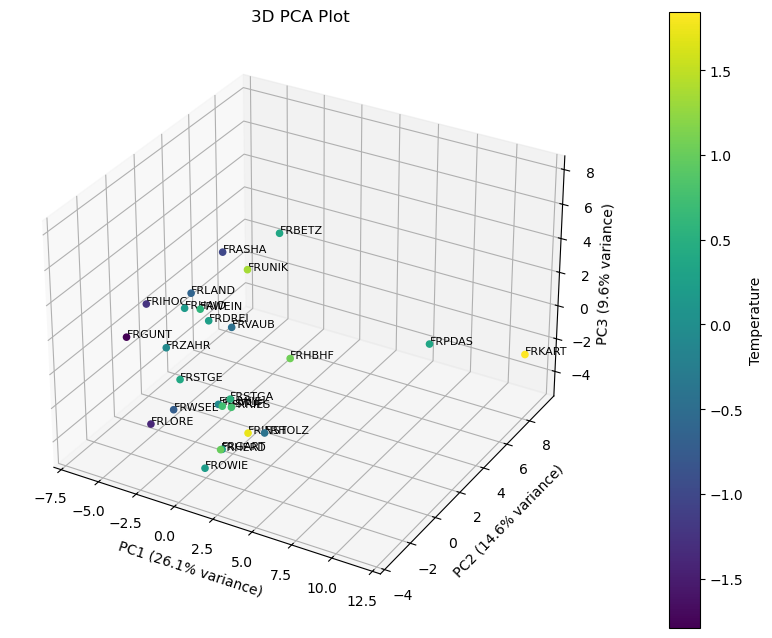

In [54]:
# Assuming params_mean has a 'station_id' column
station_ids = params_scaled.dropna().index
unique_station_ids = station_ids.unique()

# Transform the data using PCA
transformed_data = pca.transform(X_scaled)

# Assuming temp_result is a numpy array or pandas Series with the same length as transformed_data
temp_result = params_scaled.dropna()['value']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors corresponding to temp_result
sc = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], transformed_data[:, 2], 
                alpha=1, c=temp_result, cmap='viridis')

# Add color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Temperature')

# Add text labels for station_id
for station_id in unique_station_ids:
    idx = station_ids == station_id
    for i in range(len(transformed_data[idx])):
        ax.text(transformed_data[idx][i, 0], transformed_data[idx][i, 1], transformed_data[idx][i, 2], 
                station_id, size=8, zorder=1, color='k')

ax.set_xlabel(f"PC1 ({explained_variance_ratio[0]:.1%} variance)")
ax.set_ylabel(f"PC2 ({explained_variance_ratio[1]:.1%} variance)")
ax.set_zlabel(f"PC3 ({explained_variance_ratio[2]:.1%} variance)")
ax.zaxis.labelpad=-0.5

ax.set_title('3D PCA Plot')
plt.show()

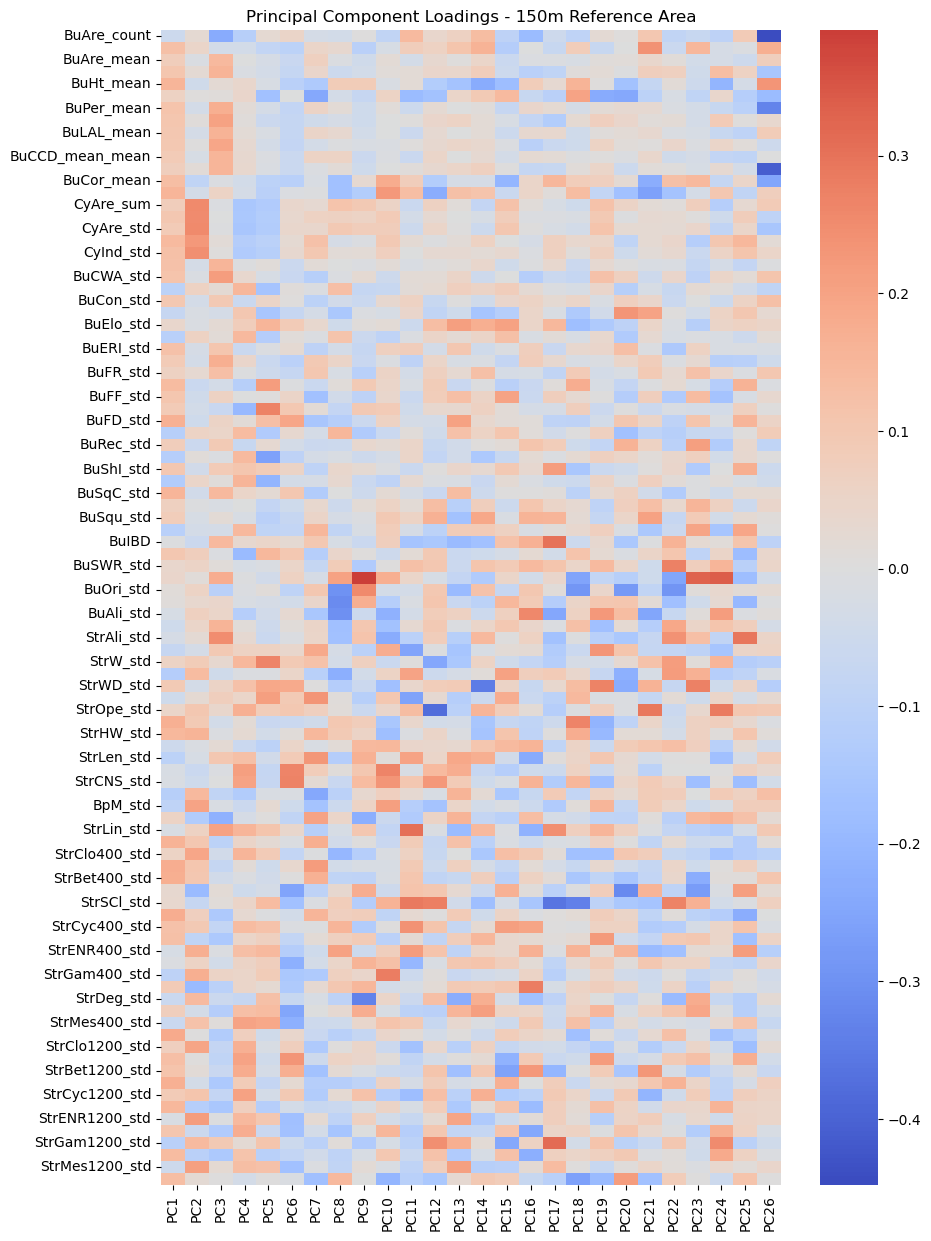

In [56]:
# Convert loadings to DataFrame for better visualization
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=X_scaled.columns)

plt.figure(figsize=(10, 15))
sns.heatmap(loadings_df, annot=False, cmap='coolwarm', center=0)
plt.title('Principal Component Loadings - 150m Reference Area')
plt.savefig('/Users/lisawink/Documents/paper1/figures/PCA_150m_loadings.svg',bbox_inches='tight')
plt.show()

In [57]:
loadings_df = loadings_df.reset_index()  # Move the index into a column
loadings_df.rename(columns={"index": "Feature"}, inplace=True)

In [63]:
pc_names = [f"PC{i}" for i in range(1, 27)]

In [64]:
# Melt the DataFrame for Altair compatibility
data_melted = loadings_df.melt(id_vars=["Feature"], var_name="Principal Component", value_name="Value")

# Create the heatmap
heatmap = alt.Chart(data_melted).mark_rect().encode(
    x=alt.X("Principal Component:O", title="Principal Components", sort=pc_names),
    y=alt.Y("Feature:O", title="Features"),
    color=alt.Color("Value:Q", scale=alt.Scale(scheme="viridis"), title="Correlation"),
    tooltip=["Feature", "Principal Component", "Value"]
).properties(
    width=800,
    height=1500,
    title="Interactive Heatmap of Features vs Principal Components"
).interactive()

heatmap.display()


alt.Chart(...)

In [65]:
# Assume `loadings` is a 2D numpy array with variables as rows and PCs as columns
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])])

# the index should be the variable names
loadings_df.index = X_scaled.columns

# Focus on the first x PCs
loadings_subset = loadings_df.iloc[:, :15]

In [66]:
correlation_matrix = loadings_subset.T.corr()
# Define a threshold for high correlation (e.g., 0.8)
threshold = 0.8

# Find variable pairs with high absolute correlation
high_corr_pairs = [(var1, var2) for var1 in correlation_matrix.columns for var2 in correlation_matrix.columns 
                   if abs(correlation_matrix.loc[var1, var2]) > threshold and var1 != var2]

In [67]:
high_corr_pairs

[('BuAre_count', 'BuIBD'),
 ('BuAre_mean', 'BuAre_std'),
 ('BuAre_mean', 'BuPer_mean'),
 ('BuAre_mean', 'BuLAL_mean'),
 ('BuAre_mean', 'BuCCD_mean_mean'),
 ('BuAre_mean', 'BuCCD_mean_std'),
 ('BuAre_mean', 'BuCWA_mean'),
 ('BuAre_mean', 'BuFR_mean'),
 ('BuAre_mean', 'BuFR_std'),
 ('BuAre_std', 'BuAre_mean'),
 ('BuAre_std', 'BuPer_mean'),
 ('BuAre_std', 'BuPer_std'),
 ('BuAre_std', 'BuLAL_mean'),
 ('BuAre_std', 'BuLAL_std'),
 ('BuAre_std', 'BuCCD_mean_std'),
 ('BuAre_std', 'BuCWA_mean'),
 ('BuAre_std', 'BuFR_std'),
 ('BuPer_mean', 'BuAre_mean'),
 ('BuPer_mean', 'BuAre_std'),
 ('BuPer_mean', 'BuPer_std'),
 ('BuPer_mean', 'BuLAL_mean'),
 ('BuPer_mean', 'BuLAL_std'),
 ('BuPer_mean', 'BuCCD_mean_mean'),
 ('BuPer_mean', 'BuCCD_mean_std'),
 ('BuPer_mean', 'BuCWA_mean'),
 ('BuPer_mean', 'BuFR_mean'),
 ('BuPer_std', 'BuAre_std'),
 ('BuPer_std', 'BuPer_mean'),
 ('BuPer_std', 'BuLAL_std'),
 ('BuPer_std', 'BuCCD_mean_std'),
 ('BuPer_std', 'BuCWA_mean'),
 ('BuPer_std', 'BuCWA_std'),
 ('BuLAL_mean',

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_17994/832106605.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1 - abs(correlation_matrix), method='ward')


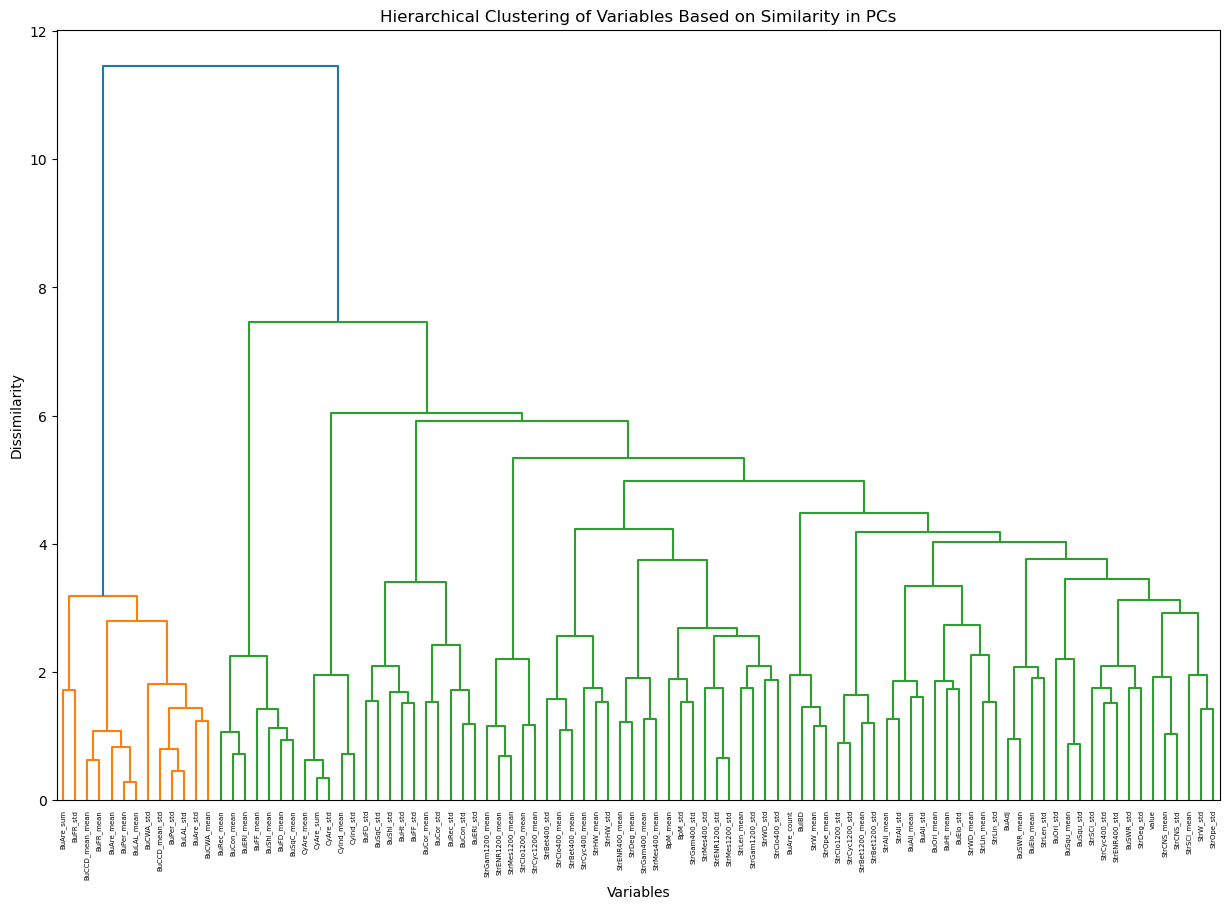

In [68]:
Z = linkage(1 - abs(correlation_matrix), method='ward')
plt.figure(figsize=(15, 10))
dendrogram(Z, labels=correlation_matrix.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering of Variables Based on Similarity in PCs")
plt.xlabel("Variables")
plt.ylabel("Dissimilarity")
plt.show()

In [69]:
loadings_df['PC1'].sort_values(ascending=False)

StrClo1200_mean    0.182771
StrBet400_mean     0.176862
StrCyc400_mean     0.175816
StrBet400_std      0.173618
StrCyc1200_mean    0.169612
                     ...   
BpM_mean          -0.112411
BuRec_mean        -0.113616
BuShI_mean        -0.116218
StrWD_mean        -0.123275
BuSqC_mean        -0.127024
Name: PC1, Length: 96, dtype: float64

In [70]:
loadings_df['PC2'].sort_values(ascending=False)

CyAre_sum          0.256654
CyAre_std          0.254841
CyAre_mean         0.250386
CyInd_std          0.244063
CyInd_mean         0.226054
                     ...   
StrMes1200_mean   -0.104758
StrENR1200_mean   -0.118953
StrLin_mean       -0.128460
StrSCl_mean       -0.189969
StrDeg_mean       -0.190071
Name: PC2, Length: 96, dtype: float64

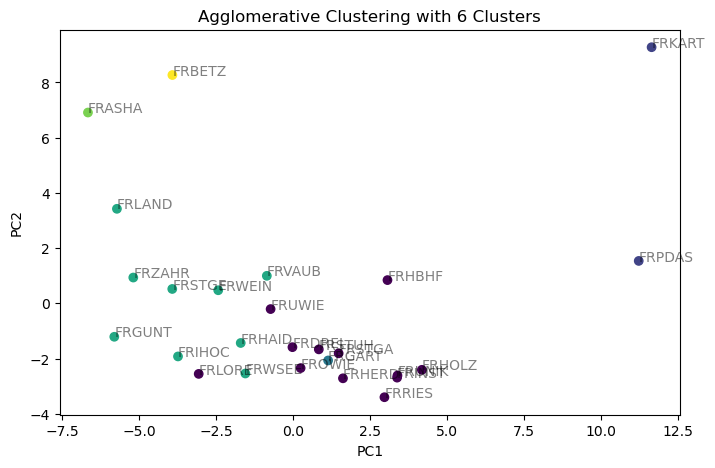

In [71]:
# find clusters in PCs

# Perform Agglomerative Clustering
n_clusters = 6
clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering.fit(transformed_data)

# Get the cluster labels
cluster_labels = clustering.labels_

# Plot the clusters
plt.figure(figsize=(8, 5))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=cluster_labels, cmap='viridis')
for i, station_id in enumerate(station_ids):
    plt.annotate(station_id, (transformed_data[i, 0], transformed_data[i, 1]),alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Agglomerative Clustering with {n_clusters} Clusters')
plt.show()


R^2: 1.0
Intercept: 0.14414687884197674
Coefficients:
PC1: 0.1314195847690876
PC2: 0.021107595066417587
PC3: 0.0035205593243927973
PC4: -0.032607400670148314
PC5: 0.003152231376464458
PC6: -0.0128905204339984
PC7: -0.1732236394025731
PC8: 0.1420905932202855
PC9: -0.0011526632374620567
PC10: -0.20489812291136106
PC11: -0.10716062652727894
PC12: -0.14356934776185043
PC13: 0.030370795952580628
PC14: 0.09528448036030818
PC15: 0.0811919248676054
PC16: -0.06856930313861935
PC17: -0.10424253269816883
PC18: -0.2608936096775253
PC19: -0.18920825649757175
PC20: 0.2146405103777998
PC21: -0.16796283108762353
PC22: 0.0815717951272285
PC23: 0.002428136262682937
PC24: -0.05276118516780089
PC25: 0.11484791308850612
PC26: 4.136549520354225


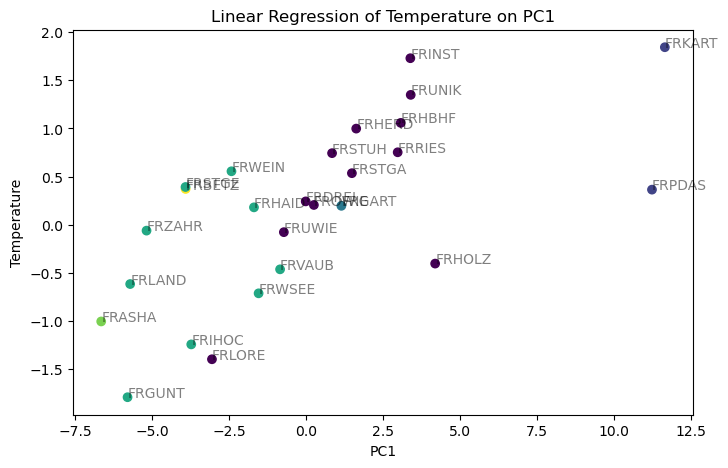

In [74]:
# do linear regression on the PCs and temp and print r squared for each PC

# Fit a linear regression model
model = LinearRegression()
model.fit(transformed_data, temp_result)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Get the R^2 value
r_squared = model.score(transformed_data, temp_result)

print(f'R^2: {r_squared}')


# Print the coefficients
print(f'Intercept: {intercept}')
print('Coefficients:')
for i, coef in enumerate(coefficients):
    print(f'PC{i+1}: {coef}')

    
    
# Plot the regression line
plt.figure(figsize=(8, 5))
plt.scatter(transformed_data[:, 0], temp_result, c=cluster_labels, cmap='viridis', linestyle='None')
plt.plot(transformed_data[:, 0], model.predict(transformed_data), color='red', linestyle='None')
for i, station_id in enumerate(station_ids):
    plt.annotate(station_id, (transformed_data[i, 0], temp_result.iloc[i]), alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('Temperature')
plt.title('Linear Regression of Temperature on PC1')
plt.show()

In [77]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.metrics import r2_score

In [111]:
# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split(transformed_data, temp_result, test_size=0.3, random_state=101) 
  
# creating a regression model 
model = LinearRegression() 
  
# fitting the model 
model.fit(X_train, y_train) 
  
# making predictions 
predictions = model.predict(X_test) 
  
# model evaluation 
print('mean_squared_error : ', mean_squared_error(y_test, predictions)) 
print('mean_absolute_error : ', mean_absolute_error(y_test, predictions)) 
print('r2_score : ', r2_score(y_test, predictions))

mean_squared_error :  0.6592178241612605
mean_absolute_error :  0.6438572874385611
r2_score :  -0.058082461155522624


Intercept: 0.1441468788419773
Coefficient: 0.13141958476908727
R^2: 0.435411638647345


<Figure size 800x500 with 0 Axes>

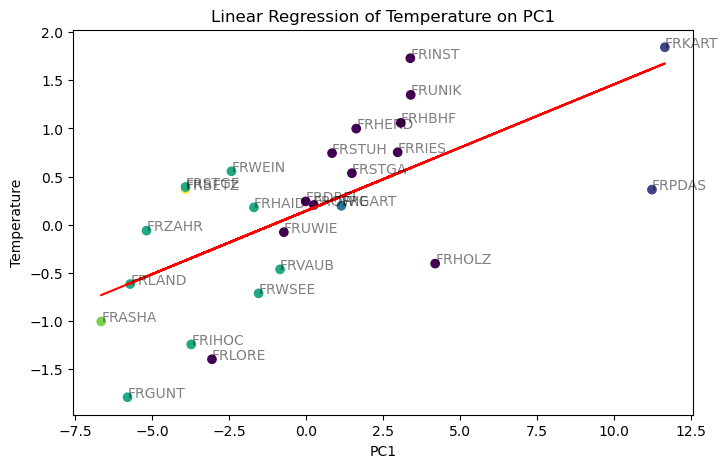

Intercept: 0.1441468788419773
Coefficient: 0.0211075950664169
R^2: 0.00626518521308439


<Figure size 800x500 with 0 Axes>

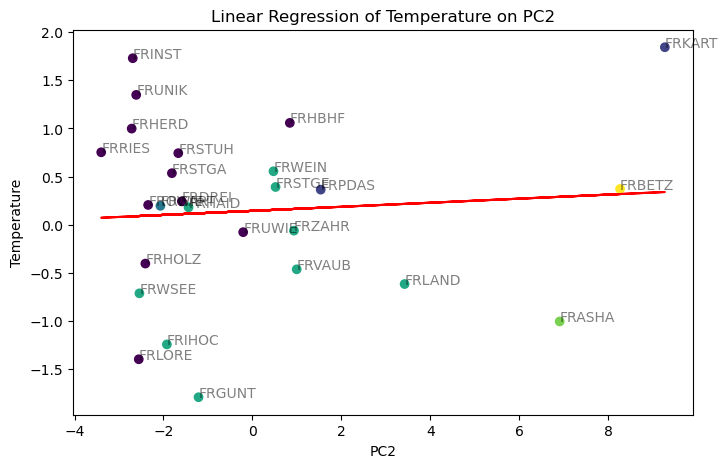

Intercept: 0.1441468788419773
Coefficient: 0.0035205593243924655
R^2: 0.00011530399795556256


<Figure size 800x500 with 0 Axes>

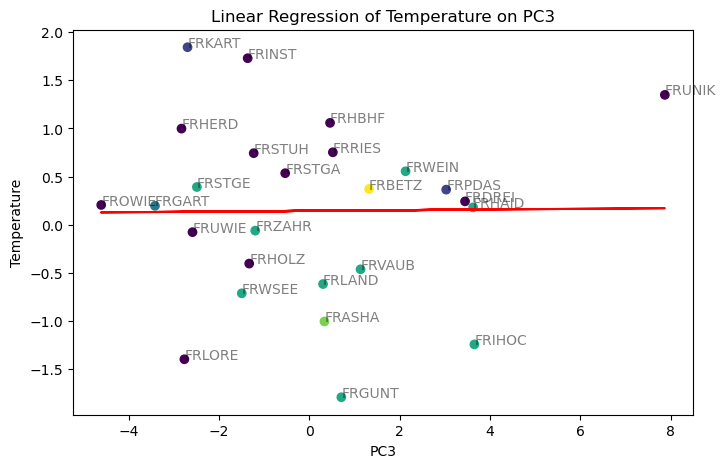

Intercept: 0.1441468788419773
Coefficient: -0.03260740067014837
R^2: 0.008664356535304174


<Figure size 800x500 with 0 Axes>

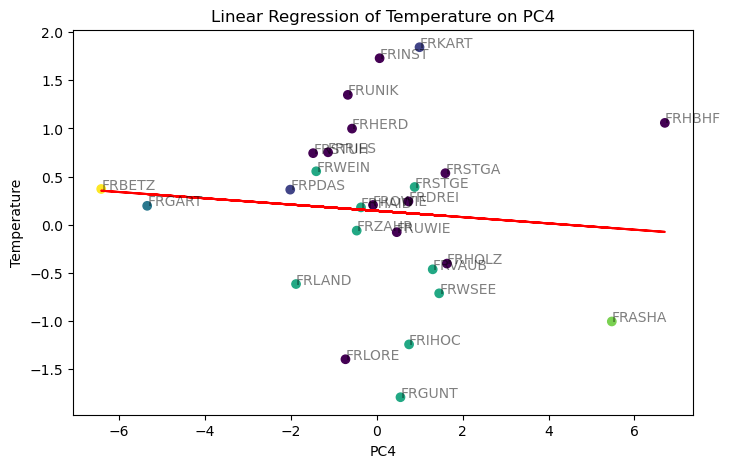

Intercept: 0.1441468788419773
Coefficient: 0.003152231376464153
R^2: 6.167574714965873e-05


<Figure size 800x500 with 0 Axes>

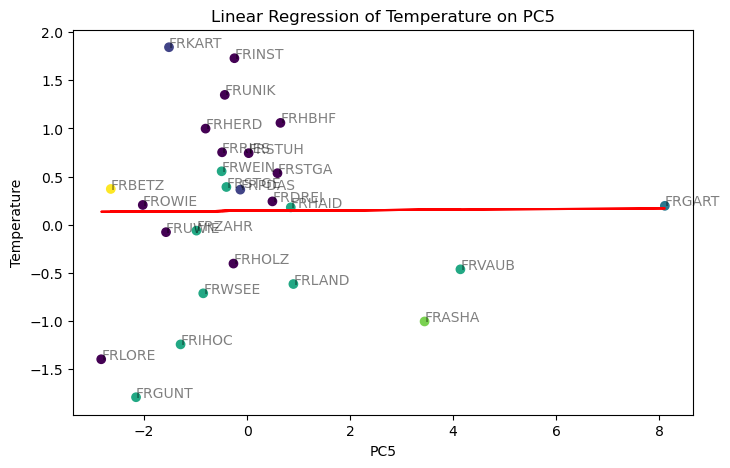

Intercept: 0.1441468788419773
Coefficient: -0.012890520433998198
R^2: 0.0008664626873382542


<Figure size 800x500 with 0 Axes>

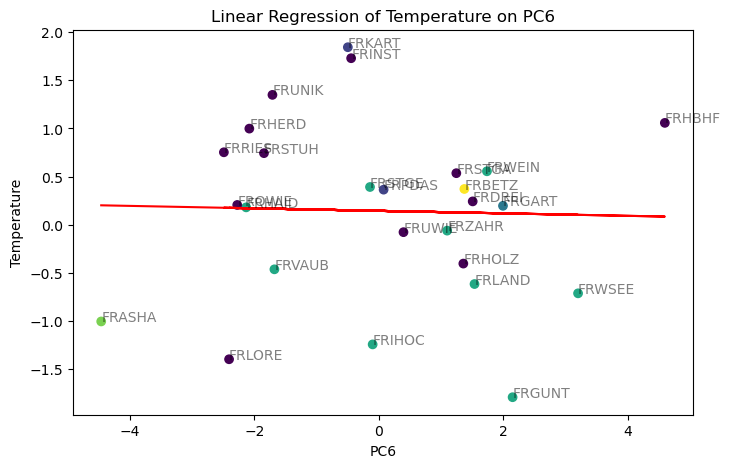

Intercept: 0.1441468788419773
Coefficient: -0.17322363940257374
R^2: 0.12437640381839099


<Figure size 800x500 with 0 Axes>

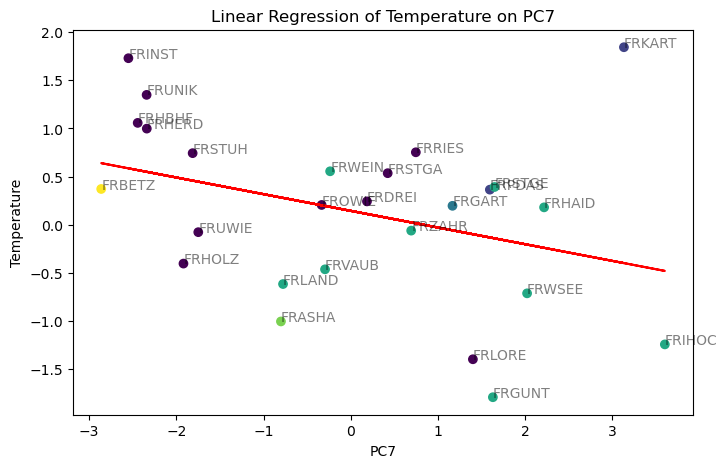

Intercept: 0.14414687884197727
Coefficient: 0.14209059322028528
R^2: 0.0750768318521734


<Figure size 800x500 with 0 Axes>

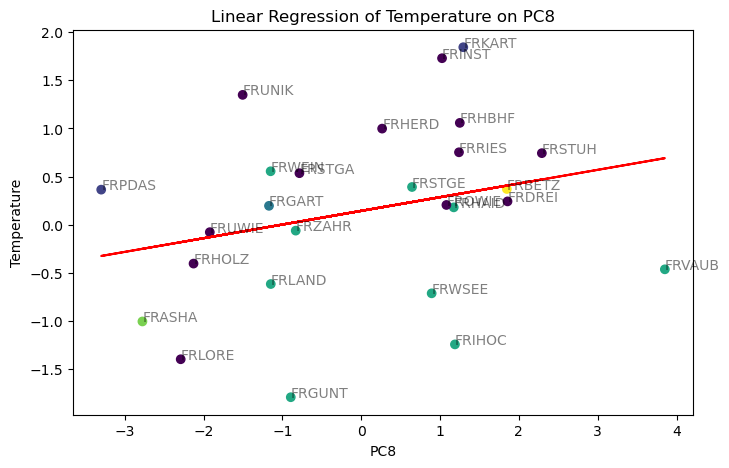

Intercept: 0.1441468788419773
Coefficient: -0.001152663237462884
R^2: 4.531532663443194e-06


<Figure size 800x500 with 0 Axes>

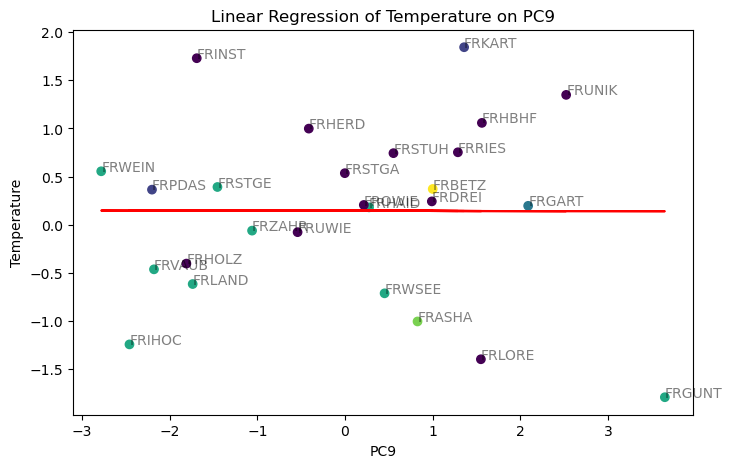

Intercept: 0.1441468788419773
Coefficient: -0.204898122911361
R^2: 0.12935942183977278


<Figure size 800x500 with 0 Axes>

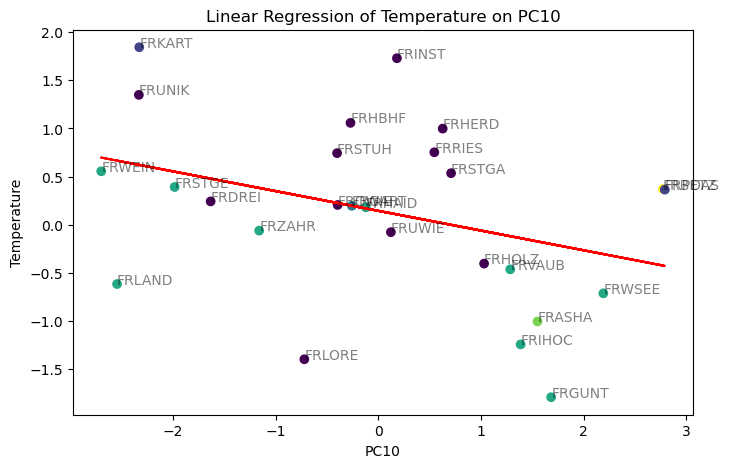

Intercept: 0.1441468788419773
Coefficient: -0.10716062652727869
R^2: 0.028142774764080336


<Figure size 800x500 with 0 Axes>

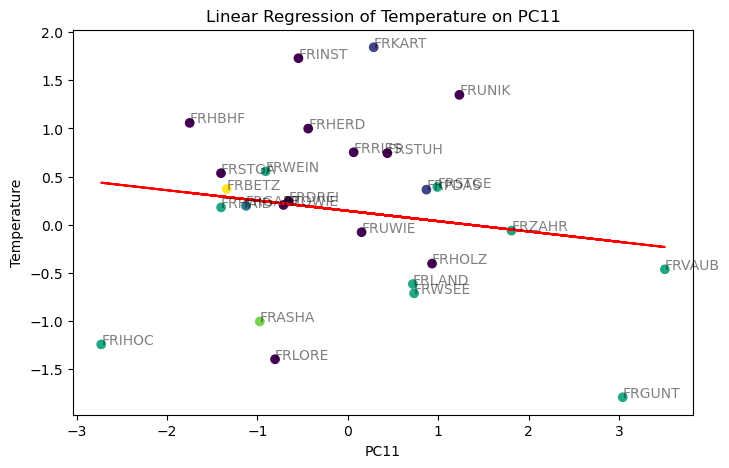

Intercept: 0.1441468788419773
Coefficient: -0.14356934776185024
R^2: 0.04164377511145867


<Figure size 800x500 with 0 Axes>

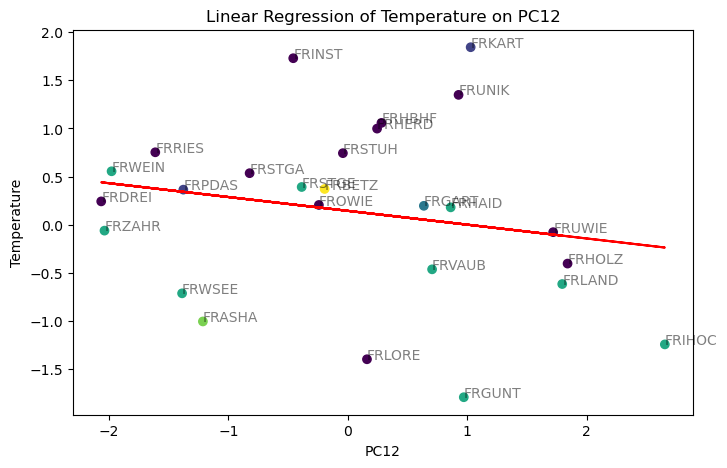

Intercept: 0.1441468788419773
Coefficient: 0.030370795952581256
R^2: 0.0016216868970665432


<Figure size 800x500 with 0 Axes>

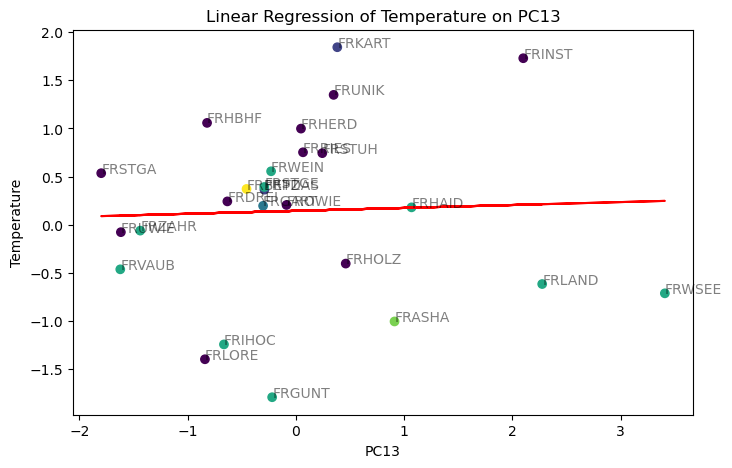

Intercept: 0.1441468788419773
Coefficient: 0.09528448036030679
R^2: 0.012557077787231585


<Figure size 800x500 with 0 Axes>

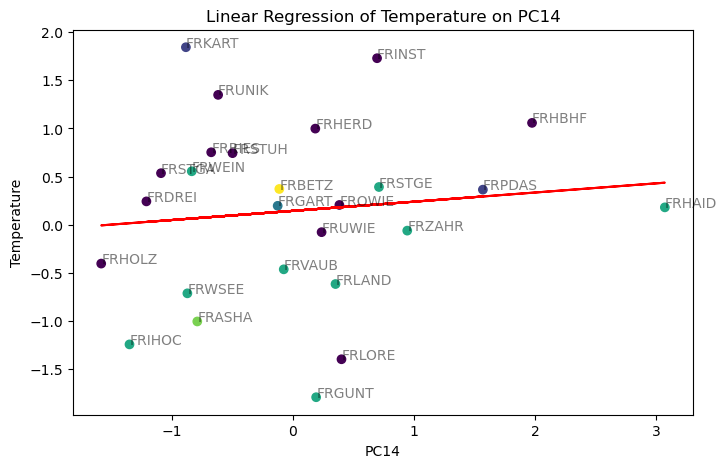

Intercept: 0.1441468788419773
Coefficient: 0.08119192486760546
R^2: 0.007693448997298957


<Figure size 800x500 with 0 Axes>

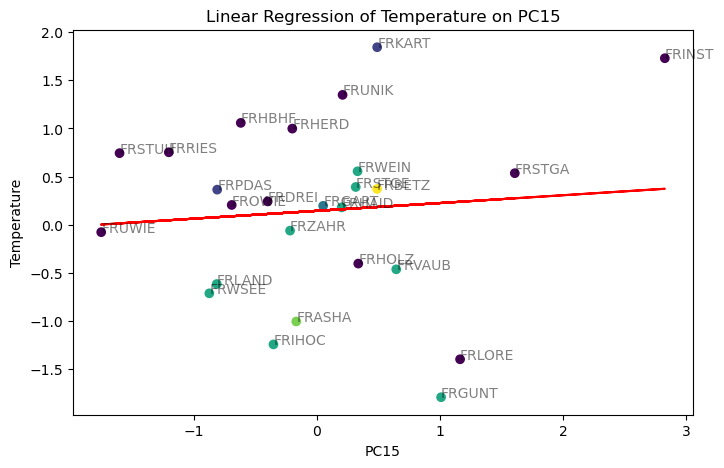

Intercept: 0.1441468788419773
Coefficient: -0.06856930313861972
R^2: 0.004464821397466956


<Figure size 800x500 with 0 Axes>

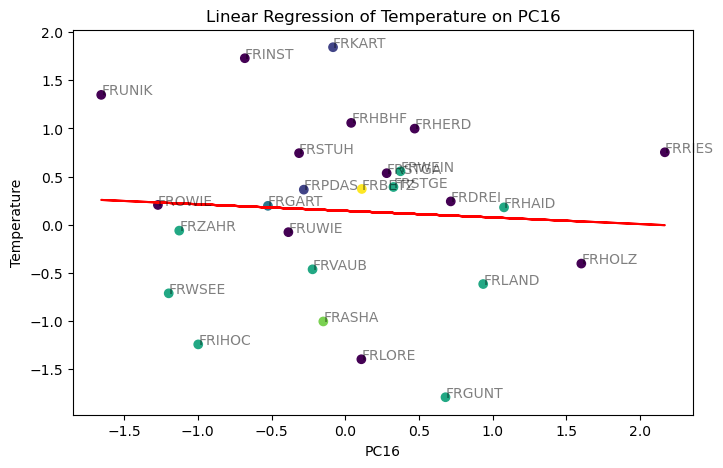

Intercept: 0.1441468788419773
Coefficient: -0.10424253269816848
R^2: 0.00893852346470314


<Figure size 800x500 with 0 Axes>

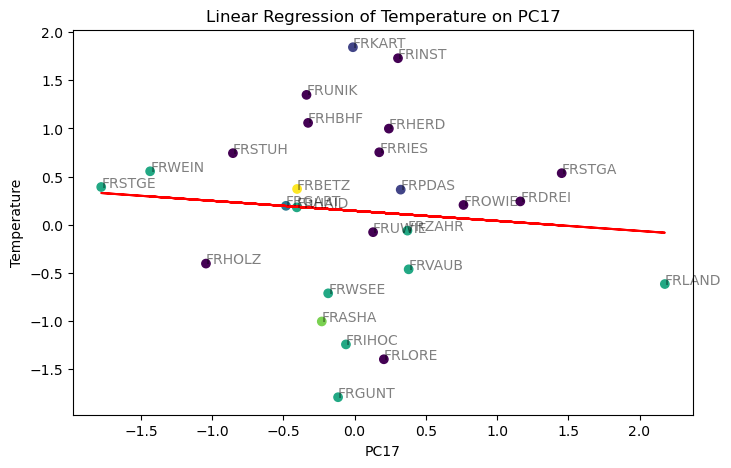

Intercept: 0.14414687884197727
Coefficient: -0.26089360967752534
R^2: 0.04596467468422161


<Figure size 800x500 with 0 Axes>

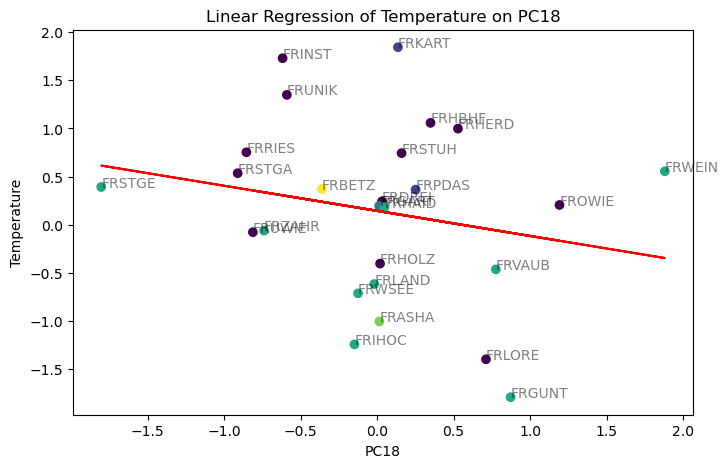

Intercept: 0.1441468788419773
Coefficient: -0.1892082564975704
R^2: 0.022055509134929263


<Figure size 800x500 with 0 Axes>

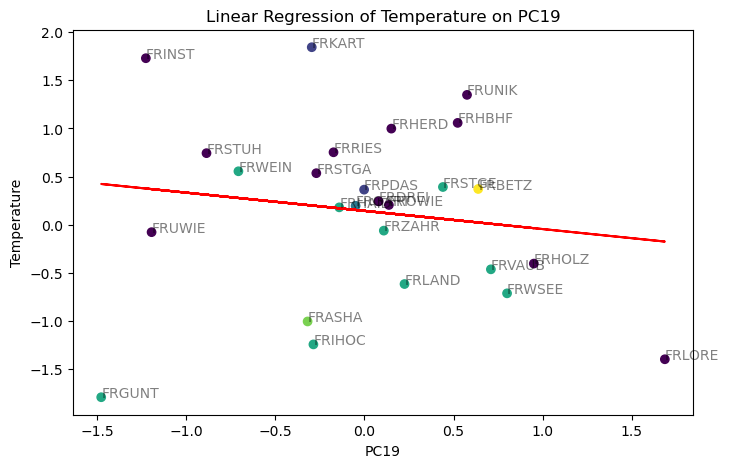

Intercept: 0.14414687884197727
Coefficient: 0.21464051037779872
R^2: 0.026560461656763623


<Figure size 800x500 with 0 Axes>

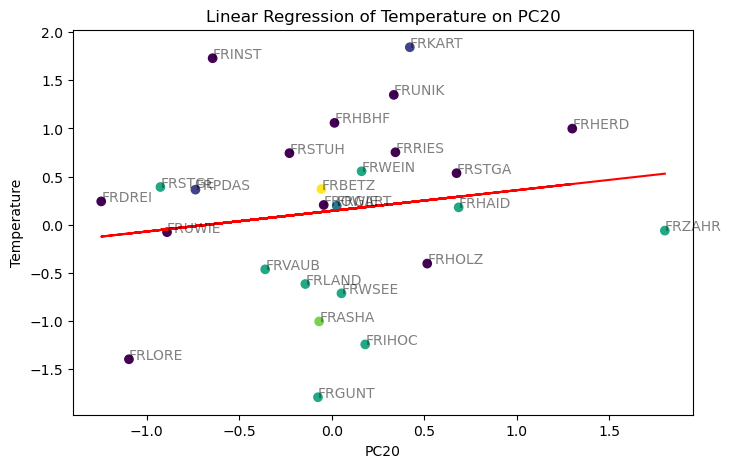

Intercept: 0.1441468788419773
Coefficient: -0.1679628310876226
R^2: 0.014198570814091371


<Figure size 800x500 with 0 Axes>

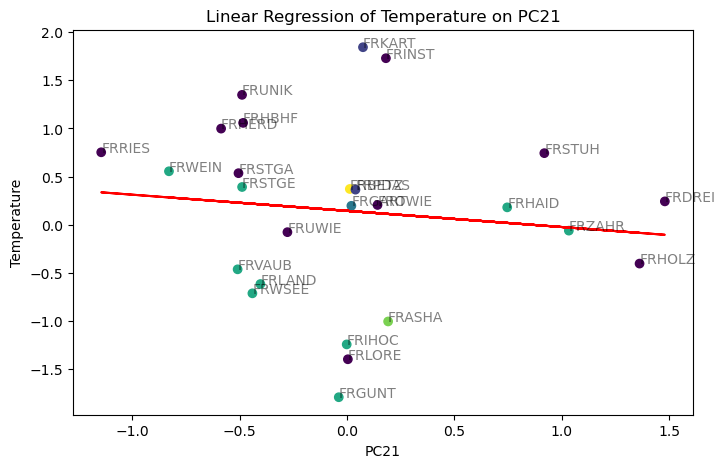

Intercept: 0.1441468788419773
Coefficient: 0.08157179512722848
R^2: 0.002964330933849846


<Figure size 800x500 with 0 Axes>

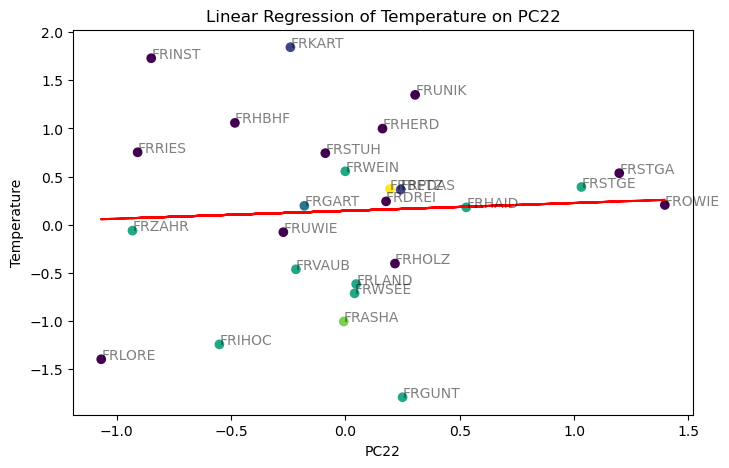

Intercept: 0.1441468788419773
Coefficient: 0.0024281362626831834
R^2: 1.5831594543103122e-06


<Figure size 800x500 with 0 Axes>

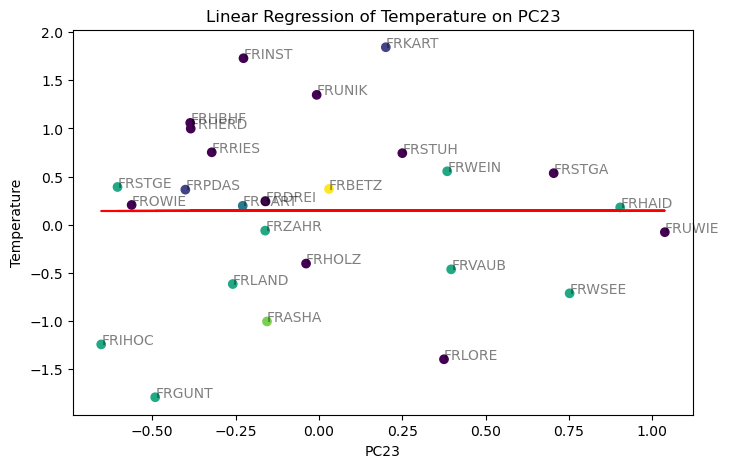

Intercept: 0.1441468788419773
Coefficient: -0.0527611851678005
R^2: 0.0006018410849142342


<Figure size 800x500 with 0 Axes>

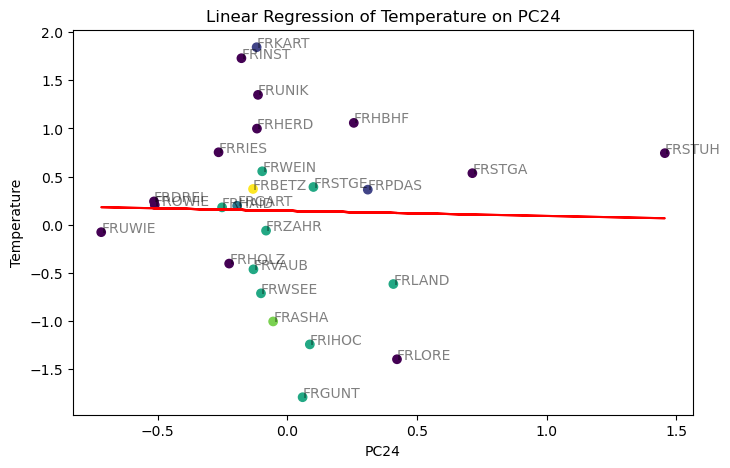

Intercept: 0.1441468788419773
Coefficient: 0.11484791308850635
R^2: 0.002389108241287685


<Figure size 800x500 with 0 Axes>

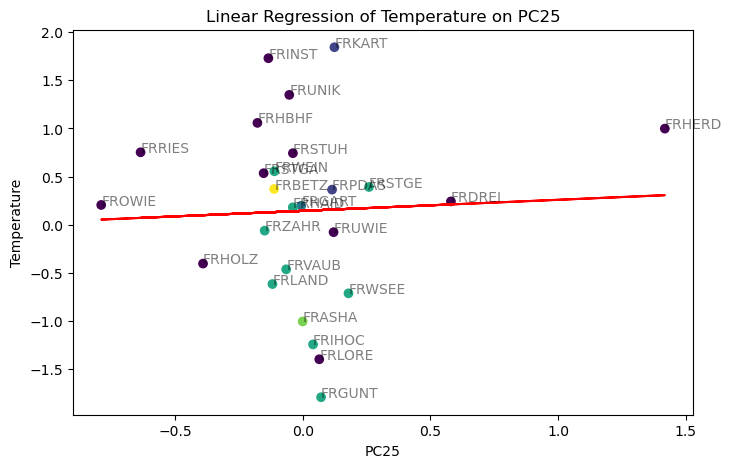

Intercept: 0.1801089951240455
Coefficient: -307302614211694.2
R^2: 0.07251592426956832


<Figure size 800x500 with 0 Axes>

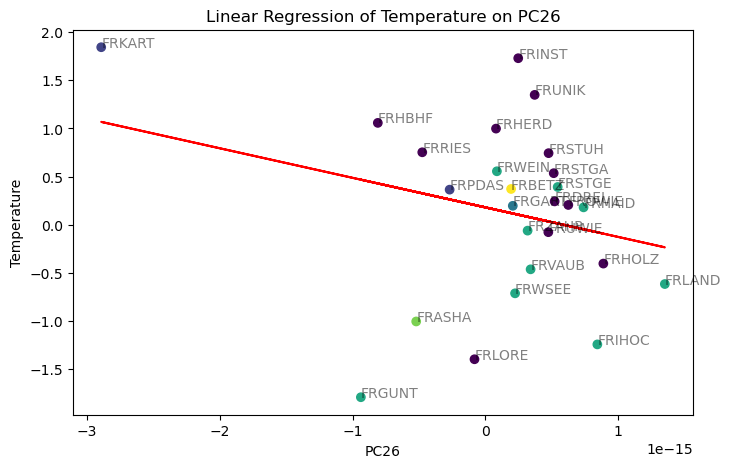

In [82]:
# regression between temperature and PC1

for i in range(0, 26):
    plt.figure(figsize=(8, 5))
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(transformed_data[:, i].reshape(-1, 1), temp_result)

    # Get the coefficients
    coefficients = model.coef_
    intercept = model.intercept_

    # Get the R^2 value
    r_squared = model.score(transformed_data[:, i].reshape(-1, 1), temp_result)

    # Print the coefficients
    print(f'Intercept: {intercept}')
    print(f'Coefficient: {coefficients[0]}')
    print(f'R^2: {r_squared}')

    # Plot the regression line

    plt.figure(figsize=(8, 5))
    plt.scatter(transformed_data[:, i], temp_result, c=cluster_labels, cmap='viridis')
    plt.plot(transformed_data[:, i], model.predict(transformed_data[:, i].reshape(-1, 1)), color='red')
    for j, station_id in enumerate(station_ids):
        plt.annotate(station_id, (transformed_data[j, i], temp_result.iloc[j]), alpha=0.5)
    plt.xlabel('PC'+str(i+1))
    plt.ylabel('Temperature')
    plt.title('Linear Regression of Temperature on PC'+str(i+1))
    plt.show()


In [88]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

######################################## Data preparation #########################################

# creating train and test sets 
X_train, X_test, y_train, y_test = train_test_split(transformed_data, temp_result, test_size=0.3, random_state=101) 
  
################################################ Train #############################################

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

# Built-in feature importance (Gini Importance)
importances = rf.feature_importances_
feature_imp_df = pd.DataFrame({'PC': range(1,27), 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

y_pred = rf.predict(X_test)
print('r2_score : ', r2_score(y_test, predictions))

    PC  Gini Importance
0    1         0.217190
7    8         0.132119
11  12         0.092194
18  19         0.063760
17  18         0.044932
24  25         0.044624
1    2         0.038405
8    9         0.037660
21  22         0.037350
9   10         0.034183
14  15         0.033340
5    6         0.028553
20  21         0.025759
4    5         0.025210
23  24         0.023561
19  20         0.018250
3    4         0.018026
13  14         0.016126
6    7         0.014848
22  23         0.012987
15  16         0.011786
2    3         0.010315
10  11         0.008967
12  13         0.006379
16  17         0.003475
25  26         0.000000
r2_score :  -0.058082461155522624


In [138]:
#r squared of linear regression using just PC1 and PC7 with test and train data
X_train, X_test, y_train, y_test = train_test_split(transformed_data[:, [0,6]], temp_result, test_size=0.2, random_state=26)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('r2_score : ', r2_score(y_test, predictions))


r2_score :  -0.6545332704425972


In [99]:
# for r squared, split into test and training

R^2: 0.559788042465736


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_17994/514316653.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(transformed_data[:, 0], transformed_data[:, 6], temp_result, c='black', cmap='viridis')


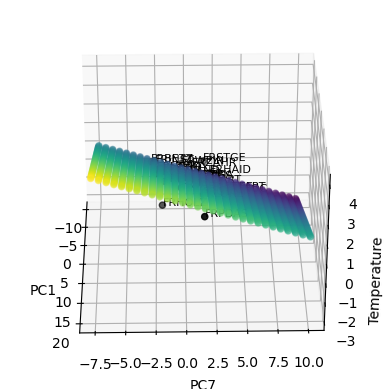

In [103]:
# linear regression of PC1 and PC4 and temp
station_ids = params_scaled.dropna().index
unique_station_ids = station_ids.unique()

# for visualisation
x_pred = np.linspace(-10, 20, 30)   # range of porosity values
y_pred = np.linspace(-7.5, 10, 30)  # range of brittleness values
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T

# Fit a linear regression model
model = LinearRegression()
model.fit(transformed_data[:, [0,6]], temp_result)
predicted = model.predict(model_viz)

# Get the coefficients
coefficients = model.coef_
intercept = model.intercept_

# Get the R^2 value
r_squared = model.score(transformed_data[:, [0,6]], temp_result)

print(f'R^2: {r_squared}')

# plot on 3d scatter plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transformed_data[:, 0], transformed_data[:, 6], temp_result, c='black', cmap='viridis')
ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, c=predicted,alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC7')
# Add text labels for station_id
for station_id in unique_station_ids:
    idx = station_ids == station_id
    for i in range(len(transformed_data[idx])):
        ax.text(transformed_data[idx][i, 0], transformed_data[idx][i, 6], temp_result[idx].iloc[i], 
                station_id, size=8, zorder=1, color='k')
ax.set_zlabel('Temperature')

for ii in np.arange(0, 360, 1):
    ax.view_init(elev=32, azim=ii)
    fig.savefig('gif_image%d.png' % ii)


plt.show()